In [1]:
%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
load_dotenv()

from IPython.display import display

from matplotlib import pyplot as plt
from transformers import pipeline
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from PIL import Image
import numpy as np
import torch
from diffusers.utils import load_image
from einops import rearrange
import torchvision.transforms as transforms
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.structures import Meshes
from text3d2video.rendering import normalize_depth_map, RasterizationSettings, MeshRasterizer
from pytorch3d.renderer import look_at_view_transform, FoVPerspectiveCameras
import torchvision.transforms.functional as TF

/home/jorge/miniconda3/envs/thesis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
device = 'cuda'
mesh: Meshes = load_objs_as_meshes(['data/cat.obj'], device=device)

/home/jorge/miniconda3/envs/thesis/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:548: UserWarning: Mtl file does not exist: data/cat.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


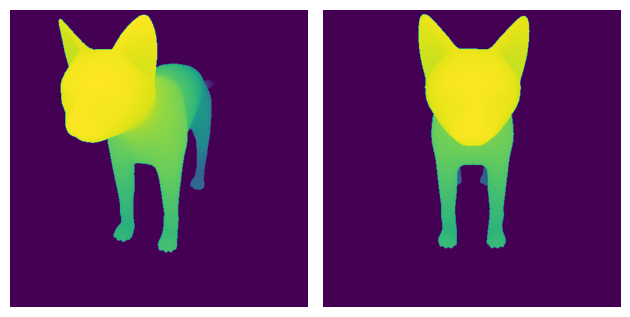

In [20]:
azim = [20, 0]
dist = 2
rotation, translation = look_at_view_transform(
    dist=dist, azim=azim, elev=20
)
cameras = FoVPerspectiveCameras(R=rotation, T=translation, device=device)
n_views = len(azim)

resolution = 512
raster_settings = RasterizationSettings(
    image_size=resolution,
    faces_per_pixel=1
)
rasterizer = MeshRasterizer(cameras=cameras, raster_settings=raster_settings)

batch_mesh = mesh.extend(n_views)
fragments = rasterizer(batch_mesh)

depth_map_normalized = normalize_depth_map(fragments.zbuf)

depth_imgs = [TF.to_pil_image(depth_map_normalized[i, :, :, 0].cpu()) for i in range(n_views)]

fig, ax = plt.subplots(1, n_views)
for i, im in enumerate(depth_imgs):
    ax[i].imshow(im)
    ax[i].axis('off')
fig.tight_layout()
# depth_imgs[0]

In [17]:
from text3d2video.diffusion import depth2img_pipe, depth2img

device = 'cuda'
pipe = depth2img_pipe(device=device)

Loading pipeline components...:  67%|██████▋   | 4/6 [00:01<00:00,  4.21it/s]/home/jorge/miniconda3/envs/thesis/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  5.16it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all pub

100%|██████████| 30/30 [00:07<00:00,  3.93it/s]


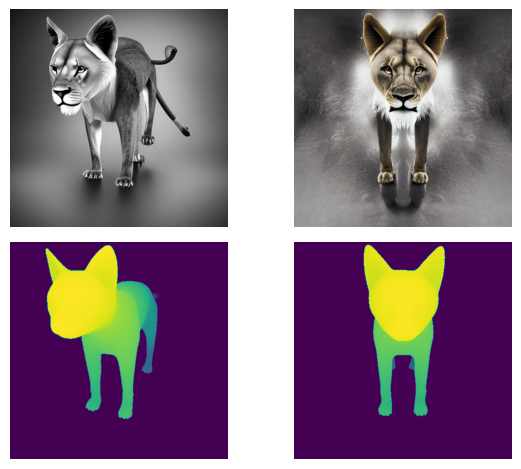

: 

In [23]:
prompts = ['Lion'] * n_views

generated_ims = depth2img(pipe, prompts, depth_imgs)

fig, ax = plt.subplots(2, n_views)
for i, im in enumerate(generated_ims):
    ax[0,i].imshow(im)
    ax[0,i].axis('off')
    ax[1,i].imshow(depth_imgs[i])
    ax[1,i].axis('off')
fig.tight_layout()

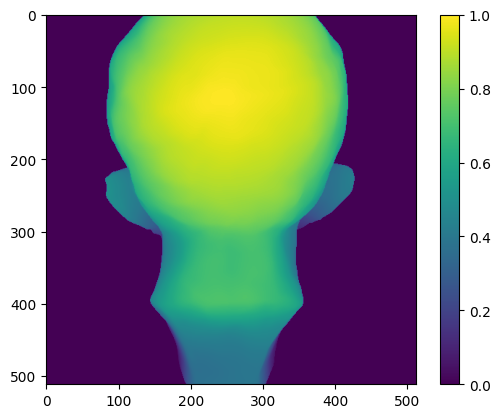

In [27]:
depth_map = torch.load('outs/depth.pt')
depth_img = TF.to_pil_image(depth_map)

plt.imshow(depth_map)
plt.colorbar()